### Import Libraries

In [1]:
#Import Cell
import torch
from torch.autograd import Variable
import numpy as np
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from time import time
import re
import json
import astropy
from astropy.stats import histogram
from scipy import stats
import astropy.units as u
import astropy.constants as constant
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.units import dimensionless
import pandas as pd
import tqdm as tqdm
from tqdm import tqdm
import importlib
print(f'Pytorch version {torch.__version__}')


Pytorch version 2.0.1


In [2]:
sys.path.append('../scripts/')
import potential_torch
import flow_torch
import toy_systems

Pytorch version 2.0.1
Pytorch version 2.0.1


### Set parameters

In [3]:
G = 1 #Gravitational Constant
M = 1 #Scale Mass
b = 1 #Scale Constant
c = np.arange(.01,5,.01)
n_samples = 1000 #Number of Samples
n_averaged = 32 #Number of Mocks averaged over


### Define Necessary Functions

In [18]:
def sfurical(x,y,z,v_x,v_y,v_z):
    
    R = np.sqrt(x**2+y**2) #for convenience
    r = np.sqrt(x**2+y**2+z**2)

    theta = np.arccos(z/r)
    phi   = np.arctan2(y,x)

    # (vx,vy,vz) -> (vr,v_{\theta},v_{\phi})
    vr     =  ( x * v_x  + y * v_y + z * v_z )/ r    
    vphi   = (y * v_x - x * v_y)/ R
    vtheta = (z * x * v_x/R  + z * y * v_y/R - R * v_z)/r
    return r, vr, vtheta, vphi

def dispersion(v):
    return np.sqrt(sum(np.square(np.subtract(v,sum(v)/len(v))))/len(v))

def vd(r,vr,vtheta,vphi,t):
    N , bin_edges= histogram(r[t],bins='blocks')
    r_center = (bin_edges[:-1] + bin_edges[1:])/2
    vmean ,_,__  = stats.binned_statistic(r[t],vr[t], statistic = 'mean', bins = bin_edges)
    error = np.multiply(1/np.sqrt(N),vmean)
    vdr     ,_,__ = stats.binned_statistic(r[t],vr[t], statistic = dispersion, bins = bin_edges)
    vdtheta     ,_,__ = stats.binned_statistic(r[t],vtheta[t], statistic = dispersion, bins = bin_edges)
    vdphi     ,_,__ = stats.binned_statistic(r[t],vphi[t], statistic = dispersion, bins = bin_edges)
    return r_center, vdr, vdtheta, vdphi

def variance(vd,vd_ideal):
    sqdiff = ((vd - vd_ideal)/vd_ideal)**2
    variance = np.sqrt(np.square(sum(sqdiff))/len(sqdiff))
    return variance

def sigma_clipped_mean(x, n_sigma=3.):
    #Computes the STD deviation for the x array
    sigma = np.std(x)
    #Computes the median value for the x array
    xmedian = np.median(x)
    xmax = xmedian + n_sigma*sigma
    xmin = xmedian - n_sigma*sigma
    xclip = np.clip(x,xmin,xmax)
    x_avg = sum(xclip)/len(xclip)
    return x_avg

def reduce_by_N(b,vdr,N):
    bin_N = int(round(len(b)/N))
    __ , bin_edges= histogram(b,bins=bin_N)
    br = (bin_edges[:-1] + bin_edges[1:])/2
    vdrr ,_,__  = stats.binned_statistic(b,vdr, statistic = 'mean', bins = bin_edges)
    return br, vdrr

vdlytic = lambda G, M, b, r : np.sqrt(G*M/(6*np.sqrt(b**2+r**2)))

### Generate Data

In [5]:
vdr = []
vdtheta = []
vdphi = []
for i in tqdm(range(0,len(b))):
    plummer_sphere = toy_systems2.PlummerSphere(G,M,b[i])
    def sample_df(n_samples, max_dist=None):
        """
        Returns phase-space locations sampled from the Plummer sphere
        distribution function. The shape of the output is
        (n_samples, 6).
        """
        #Generates coordinates in phase-space from that lie in a spherical spatial region.
        x,v = plummer_sphere.sample_df(n_samples)
        if max_dist is not None:
            r2 = np.sum(x**2, axis=1)
            idx = (r2 < max_dist**2)
            x = x[idx]
            v = v[idx]
        return x , v

    vdr_avg = []
    vdtheta_avg = []
    vdphi_avg = []

    for m in range(0,n_averaged):

        q, p = sample_df(n_samples) #Generate Mock Data
        r, vr, vtheta, vphi = sfurical(q.T[0],q.T[1],q.T[2],p.T[0],p.T[1],p.T[2]) #Convert to spherical coordinates
        N , bin_edges= histogram(r,bins='blocks') #bin data
        r_center = (bin_edges[:-1] + bin_edges[1:])/2 #define bin centers
        
        #Calculate binning errors
        vmean ,_,__  = stats.binned_statistic(r,vr, statistic = 'mean', bins = bin_edges)
        error = np.multiply(1/np.sqrt(N),vmean)

        #Calculate velocity dispersions
        vdr0     ,_,__ = stats.binned_statistic(r,vr, statistic = dispersion, bins = bin_edges)
        vdtheta0     ,_,__ = stats.binned_statistic(r,vtheta, statistic = dispersion, bins = bin_edges)
        vdphi0     ,_,__ = stats.binned_statistic(r,vphi, statistic = dispersion, bins = bin_edges)   
        vd_ideal0 = vdlytic(G,M,b[i],r_center)

        #Calculate normalized variance from ideal
        vdr_avg += [variance(vdr0,vd_ideal0)]
        vdtheta_avg += [variance(vdtheta0,vd_ideal0)]
        vdphi_avg += [variance(vdphi0,vd_ideal0)]

    vdr += [sigma_clipped_mean(vdr_avg,1)]
    vdtheta += [sigma_clipped_mean(vdtheta_avg,1)]
    vdphi += [sigma_clipped_mean(vdphi_avg,1)]



  0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 499/499 [1:55:48<00:00, 13.92s/it]  


### Plot Results

In [29]:
vdr0 = np.ones_like(b)*(np.mean(vdr))
vdtheta0 = np.ones_like(b)*(np.mean(vdtheta))
vdphi0 = np.ones_like(b)*(np.mean(vdphi))

N = 5
br, vdrr = reduce_by_N(b,vdr,N)
br, vdthetar = reduce_by_N(b,vdtheta,N)
br, vdphir = reduce_by_N(b,vdphi,N)

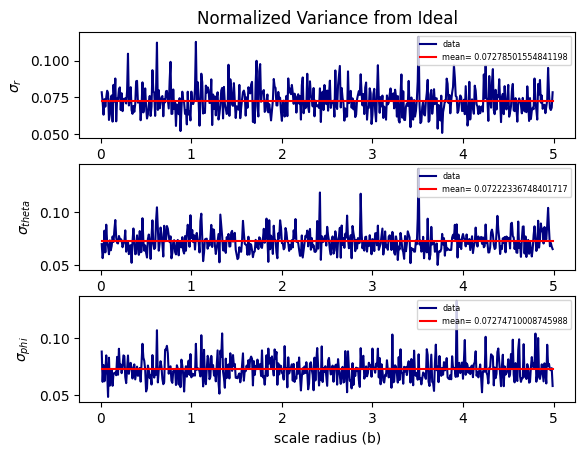

In [13]:
    figure, axis = plt.subplots(3, 1)
    plt.subplots_adjust(hspace = .25)
    ymax = .25


    #First plot - Radial Dispersions
    axis[0].plot(b,vdr, label = 'data', color = 'navy')
    axis[0].plot(b,vdr0, label = 'mean= ' + str(np.mean(vdr)), color = 'red')
    axis[0].set_ylabel('$\sigma_r$')
    axis[0].set_title('Normalized Variance from Ideal')
    axis[0].legend(fontsize = 'xx-small', loc = 'upper right')
    #axis[0].set_ylim(0,ymax)

    #Second Plot - Theta Dispersions
    axis[1].plot(b,vdtheta, label = 'data', color = 'navy')
    axis[1].plot(b,vdtheta0, label = 'mean= ' + str(np.mean(vdtheta)), color = 'red')
    axis[1].set_ylabel('$\sigma_{theta}$')
    axis[1].legend(fontsize= 'xx-small', loc = 'upper right')
    #axis[1].set_ylim(0,ymax)

    #Third Plot - Phi Dispersions
    axis[2].plot(b,vdphi, label = 'data', color = 'navy')
    axis[2].plot(b,vdphi0, label = 'mean= ' + str(np.mean(vdphi)), color = 'red')
    axis[2].set_xlabel('scale radius (b)')
    axis[2].set_ylabel('$\sigma_{phi}$')
    axis[2].legend(fontsize= 'xx-small', loc = 'upper right')
    #axis[2].set_ylim(0,ymax)

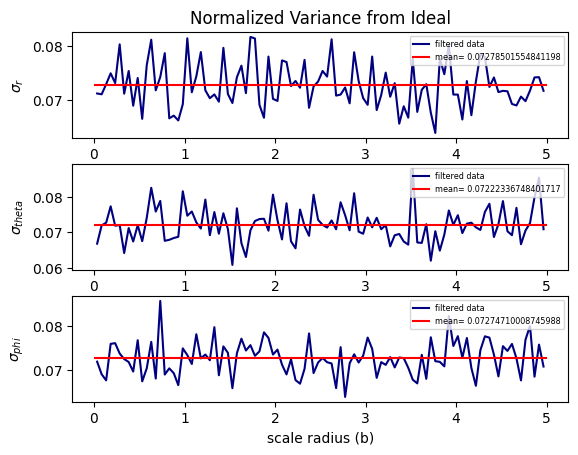

In [30]:
    figure, axis = plt.subplots(3, 1)
    plt.subplots_adjust(hspace = .25)
    ymax = .25


    #First plot - Radial Dispersions
    axis[0].plot(br,vdrr, label = 'filtered data', color = 'navy')
    axis[0].plot(b,vdr0, label = 'mean= ' + str(np.mean(vdr)), color = 'red')
    axis[0].set_ylabel('$\sigma_r$')
    axis[0].set_title('Normalized Variance from Ideal')
    axis[0].legend(fontsize = 'xx-small', loc = 'upper right')
    #axis[0].set_ylim(0,ymax)

    #Second Plot - Theta Dispersions
    axis[1].plot(br,vdthetar, label = 'filtered data ', color = 'navy')
    axis[1].plot(b,vdtheta0, label = 'mean= ' + str(np.mean(vdtheta)), color = 'red')
    axis[1].set_ylabel('$\sigma_{theta}$')
    axis[1].legend(fontsize= 'xx-small', loc = 'upper right')
    #axis[1].set_ylim(0,ymax)

    #Third Plot - Phi Dispersions
    axis[2].plot(br,vdphir, label = 'filtered data', color = 'navy')
    axis[2].plot(b,vdphi0, label = 'mean= ' + str(np.mean(vdphi)), color = 'red')
    axis[2].set_xlabel('scale radius (b)')
    axis[2].set_ylabel('$\sigma_{phi}$')
    axis[2].legend(fontsize= 'xx-small', loc = 'upper right')
    #axis[2].set_ylim(0,ymax)